In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

### 1.  Bộ dữ liệu ARE Historical Data

In [49]:
df1 = pd.read_csv('ARE-Historical-Data.csv')
df1

,Date,Price,Open,High,Low,Vol.,Change %
0,1/2/2015,89.79,89.11,89.88,88.54,277.62K,1.18%
1,1/5/2015,90.87,89.31,91.17,89.15,359.76K,1.20%
2,1/6/2015,91.33,90.65,91.56,90.25,1.33M,0.51%
3,1/7/2015,92.57,91.55,92.57,90.69,543.40K,1.36%
4,1/8/2015,93.63,92.57,93.85,92.43,718.78K,1.15%
...,...,...,...,...,...,...,...
2124,6/12/2023,121.00,120.28,121.71,120.03,788.83K,0.34%
2125,6/13/2023,122.06,121.15,123.93,120.50,846.11K,0.88%
2126,6/14/2023,121.92,122.99,123.79,120.83,1.01M,-0.11%
2127,6/15/2023,121.15,121.16,121.78,119.87,931.08K,-0.63%


In [50]:
df1 = df1[['Price']]
df1 = df1.dropna() # Drop missing values
df1

,Price
0,89.79
1,90.87
2,91.33
3,92.57
4,93.63
...,...
2124,121.00
2125,122.06
2126,121.92
2127,121.15


In [51]:
df1.isnull().sum()

Price    0
dtype: int64

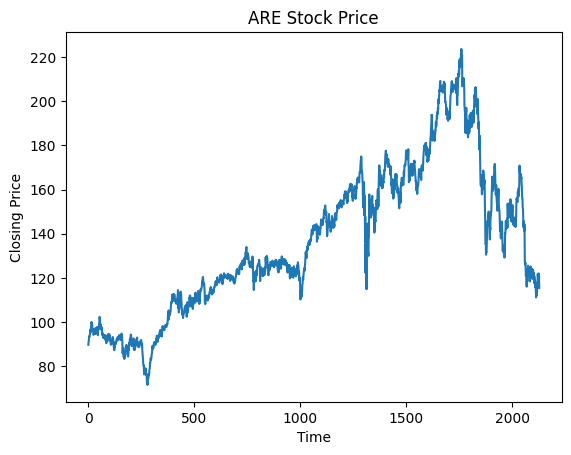

In [52]:
#Vẽ biểu đồ chuỗi thời gian của giá đóng cửa để kiểm tra xu hướng và dao động của dữ liệu:
import matplotlib.pyplot as plt
plt.plot(df1)
plt.title('ARE Stock Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.show()

* Nhìn vào biểu đồ, chúng ta có thể thấy rằng giá đóng cửa của ARE có xu hướng tăng theo thời gian, nhưng đồng thời cũng có những biến động và dao động lớn. Điều này cho thấy dữ liệu không ổn định và có thể cần được xử lý trước khi sử dụng trong mô hình Holt-Winters.

In [53]:
# Sử dụng ADF (Augmented Dickey-Fuller) test để kiểm tra tính ổn định của dữ liệu
from statsmodels.tsa.stattools import adfuller
result = adfuller(df1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.630539
p-value: 0.467209
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


* Kết quả cho thấy p-value > 0.05 => dữ liệu không ổn định

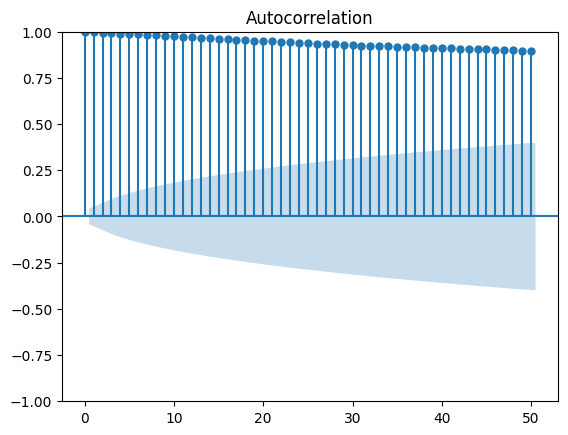

In [54]:
#Kiểm tra tính chu kỳ của dữ liệu
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df1, lags=50)
plt.show()

* Nhìn đồ thị ta thấy dữ liệu không có tính chu kỳ rõ ràng

Vậy dữ liệu ARE Historical Data ban đầu không phù hợp cho mô hình Holt-winters

In [55]:
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [56]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the model
model = ExponentialSmoothing(train_data, seasonal_periods=30, trend='add', seasonal='add').fit()

In [57]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.forecast(len(x_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.forecast(len(x_val))

In [58]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df1.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.forecast(len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
1277    164.506942
1278    164.901733
1279    164.738194
1280    164.968221
1281    164.815117
1282    165.016566
1283    165.153945
1284    165.194209
1285    165.499217
1286    165.622081
1287    165.774002
1288    165.449235
1289    165.579955
1290    165.709069
1291    165.673724
1292    165.949547
1293    166.142325
1294    166.299543
1295    166.354680
1296    166.367247
1297    166.262594
1298    166.372581
1299    165.995140
1300    166.126740
1301    166.176995
1302    166.207014
1303    166.398892
1304    165.996819
1305    166.325174
1306    166.280280
dtype: float64


In [59]:
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mae = np.mean(np.abs(y_pred - y_test))
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 39.66364377969412
Testing RMSE: 13.900374340543644
Testing MAE: 11.364748496800518
Validation MAE: 35.591173875098534
Testing MAPE: 7.0344576479608065
Validation MAPE: 23.83469516122692


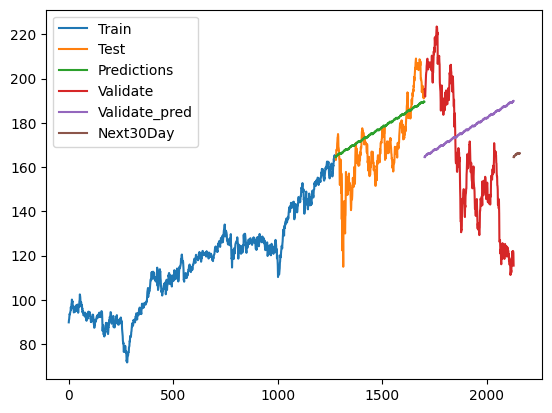

In [60]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, val_data['Price'])
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate', 'Validate_pred','Next30Day'])
plt.show()

### 2.  Bộ dữ liệu ARI Historical Data

In [61]:
df2 = pd.read_csv('ARI-Historical-Data.csv')
df2

,Date,Price,Open,High,Low,Vol.,Change %
0,1/2/2015,16.54,16.49,16.55,16.35,184.56K,1.10%
1,1/5/2015,16.51,16.47,16.63,16.45,387.43K,-0.18%
2,1/6/2015,16.42,16.60,16.64,16.37,225.81K,-0.55%
3,1/7/2015,16.63,16.48,16.65,16.44,492.81K,1.28%
4,1/8/2015,16.49,16.69,16.69,16.45,440.70K,-0.84%
...,...,...,...,...,...,...,...
2124,6/12/2023,11.09,10.83,11.11,10.83,754.88K,2.21%
2125,6/13/2023,11.22,11.12,11.25,11.08,799.04K,1.17%
2126,6/14/2023,11.19,11.27,11.38,11.09,876.19K,-0.27%
2127,6/15/2023,11.42,11.15,11.44,11.14,1.07M,2.06%


In [62]:
df2 = df2[['Price']]
df2 = df2.dropna() # Drop missing values
df2

,Price
0,16.54
1,16.51
2,16.42
3,16.63
4,16.49
...,...
2124,11.09
2125,11.22
2126,11.19
2127,11.42


In [63]:
df2.isnull().sum()

Price    0
dtype: int64

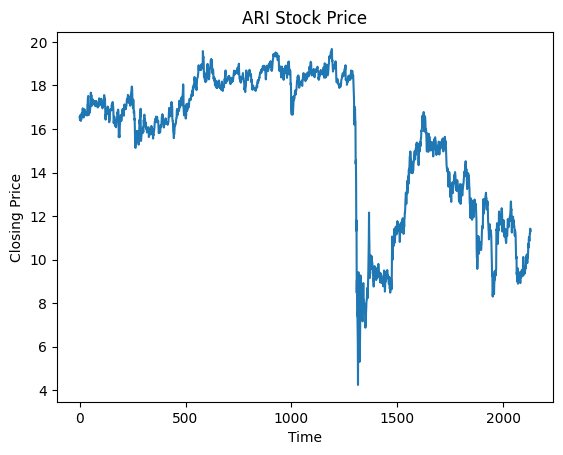

In [64]:
#Vẽ biểu đồ chuỗi thời gian của giá đóng cửa để kiểm tra xu hướng và dao động của dữ liệu:
import matplotlib.pyplot as plt
plt.plot(df2)
plt.title('ARI Stock Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.show()

* Nhìn vào biểu đồ, chúng ta có thể thấy rằng giá đóng cửa của ARE có xu hướng tăng theo thời gian, nhưng đồng thời cũng có những biến động và dao động lớn. Điều này cho thấy dữ liệu không ổn định và có thể cần được xử lý trước khi sử dụng trong mô hình Holt-Winters.

In [65]:
# Sử dụng ADF (Augmented Dickey-Fuller) test để kiểm tra tính ổn định của dữ liệu
from statsmodels.tsa.stattools import adfuller
result = adfuller(df2)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.708179
p-value: 0.426903
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


* Kết quả cho thấy p-value > 0.05 => dữ liệu không ổn định

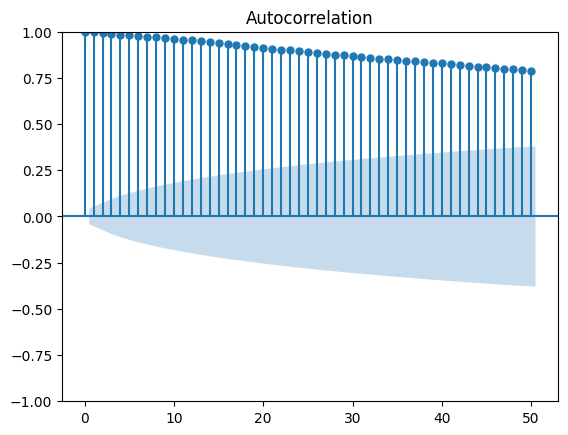

In [66]:
#Kiểm tra tính chu kỳ của dữ liệu
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df2, lags=50)
plt.show()

* Nhìn đồ thị ta thấy dữ liệu không có tính chu kỳ rõ ràng

Vậy dữ liệu ARE Historical Data ban đầu không phù hợp cho mô hình Holt-winters

In [67]:
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df2))
test_size = int(0.2 * len(df2))
val_size = len(df2) - train_size - test_size

train_data = df2[:train_size]
test_data = df2[train_size:train_size+test_size]
val_data = df2[train_size+test_size:]

In [68]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the model
model = ExponentialSmoothing(train_data, seasonal_periods=30, trend='add', seasonal='add').fit()

In [69]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.forecast(len(x_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.forecast(len(x_val))

In [70]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df2.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.forecast(len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
1277    18.349275
1278    18.348577
1279    18.312621
1280    18.317151
1281    18.315956
1282    18.307388
1283    18.333809
1284    18.366674
1285    18.418136
1286    18.368365
1287    18.382199
1288    18.357182
1289    18.385517
1290    18.404098
1291    18.404325
1292    18.425963
1293    18.431082
1294    18.413166
1295    18.415015
1296    18.413388
1297    18.441289
1298    18.445477
1299    18.425690
1300    18.427082
1301    18.417803
1302    18.453831
1303    18.462914
1304    18.420807
1305    18.433593
1306    18.413368
dtype: float64


In [71]:
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mae = np.mean(np.abs(y_pred - y_test))
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 6.972911146758515
Testing RMSE: 7.218025130359044
Testing MAE: 6.499002656690669
Validation MAE: 6.716399395832731
Testing MAPE: 65.42174866686608
Validation MAPE: 59.71495462390901


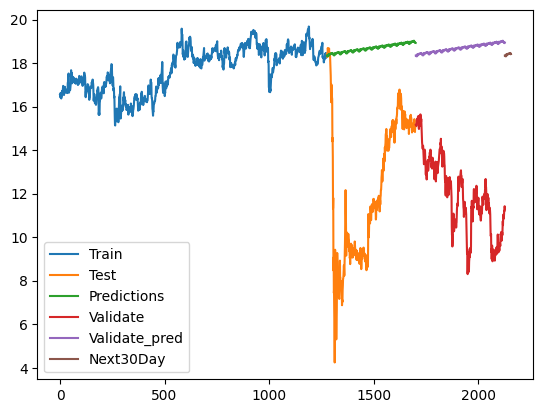

In [72]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, val_data['Price'])
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate', 'Validate_pred','Next30Day'])
plt.show()

### 3.  Bộ dữ liệu MAA Historical Data

In [73]:
df2 = pd.read_csv('MAA-Historical-Data.csv')
df2

,Date,Price,Open,High,Low,Vol.,Change %
0,1/2/2015,76.15,74.47,76.19,74.47,276.36K,1.97%
1,1/5/2015,75.86,75.86,76.34,75.43,549.69K,-0.38%
2,1/6/2015,77.18,76.28,77.83,76.27,833.74K,1.74%
3,1/7/2015,78.14,76.48,78.34,76.29,544.77K,1.24%
4,1/8/2015,78.34,78.14,78.46,77.36,544.03K,0.26%
...,...,...,...,...,...,...,...
2124,6/12/2023,152.73,153.97,153.97,151.50,489.48K,-1.00%
2125,6/13/2023,153.68,151.82,153.78,151.28,513.48K,0.62%
2126,6/14/2023,153.40,154.35,155.11,152.47,388.42K,-0.18%
2127,6/15/2023,154.17,153.20,154.92,152.00,549.30K,0.50%


In [74]:
df2 = df2[['Price']]
df2 = df2.dropna() # Drop missing values
df2

,Price
0,76.15
1,75.86
2,77.18
3,78.14
4,78.34
...,...
2124,152.73
2125,153.68
2126,153.40
2127,154.17


In [75]:
df2.isnull().sum()

Price    0
dtype: int64

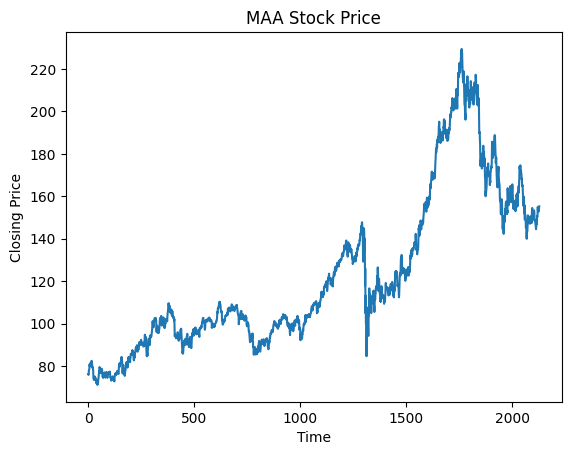

In [76]:
#Vẽ biểu đồ chuỗi thời gian của giá đóng cửa để kiểm tra xu hướng và dao động của dữ liệu:
import matplotlib.pyplot as plt
plt.plot(df2)
plt.title('MAA Stock Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.show()

* Nhìn vào biểu đồ, chúng ta có thể thấy rằng giá đóng cửa của ARE có xu hướng tăng theo thời gian, nhưng đồng thời cũng có những biến động và dao động lớn. Điều này cho thấy dữ liệu không ổn định và có thể cần được xử lý trước khi sử dụng trong mô hình Holt-Winters.

In [77]:
# Sử dụng ADF (Augmented Dickey-Fuller) test để kiểm tra tính ổn định của dữ liệu
from statsmodels.tsa.stattools import adfuller
result = adfuller(df2)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.227941
p-value: 0.661462
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


* Kết quả cho thấy p-value > 0.05 => dữ liệu không ổn định

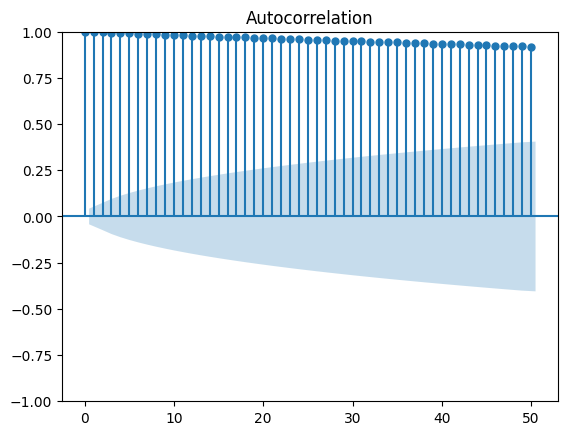

In [78]:
#Kiểm tra tính chu kỳ của dữ liệu
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df2, lags=50)
plt.show()

* Nhìn đồ thị ta thấy dữ liệu không có tính chu kỳ rõ ràng

Vậy dữ liệu ARE Historical Data ban đầu không phù hợp cho mô hình Holt-winters

In [79]:
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df2))
test_size = int(0.2 * len(df2))
val_size = len(df2) - train_size - test_size

train_data = df2[:train_size]
test_data = df2[train_size:train_size+test_size]
val_data = df2[train_size+test_size:]

In [80]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the model
model = ExponentialSmoothing(train_data, seasonal_periods=30, trend='add', seasonal='add').fit()

In [81]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.forecast(len(x_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.forecast(len(x_val))

In [82]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df2.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.forecast(len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
1277    136.527088
1278    136.681830
1279    136.557323
1280    136.596854
1281    136.579678
1282    136.387104
1283    136.557573
1284    136.546372
1285    136.835399
1286    136.899416
1287    136.958953
1288    136.645412
1289    136.894218
1290    136.986098
1291    137.031937
1292    137.206617
1293    137.296384
1294    137.333403
1295    137.246379
1296    137.208486
1297    137.140149
1298    137.398046
1299    137.352731
1300    137.457675
1301    137.364407
1302    137.556072
1303    137.813509
1304    137.799799
1305    138.142624
1306    137.996767
dtype: float64


In [83]:
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mae = np.mean(np.abs(y_pred - y_test))
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 42.99607388798634
Testing RMSE: 23.98332644740863
Testing MAE: 21.39543668113945
Validation MAE: 32.96083299664725
Testing MAPE: 16.360591644379618
Validation MAPE: 16.857232343643645


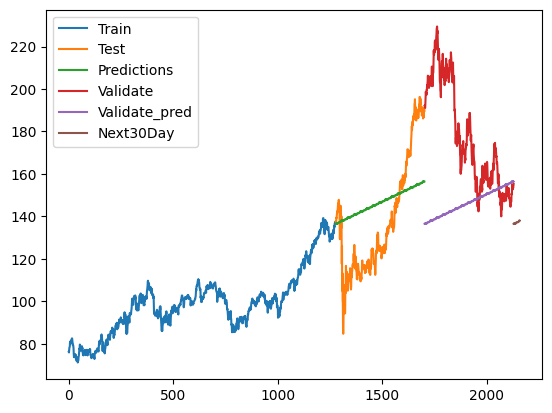

In [84]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, val_data['Price'])
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate', 'Validate_pred','Next30Day'])
plt.show()